## Settings

In [1]:
%cd /content/drive/MyDrive/Dyetec

/content/drive/MyDrive/Dyetec


In [2]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=5fcdf9856bd20addb799766a0949ca8d8500131c2320722ea52a36ac90f1c223
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


In [3]:
import os
import random
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [4]:
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

### Configurations

In [91]:
#=====  XGBoost  =====
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.1
MAX_DEPTH = 20
N_ESTIMATORS = 100
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 10  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

# 'dart'인 경우에만 적용 - overfitting 방지
NORMALIZE_TYPE = 'tree'  # how to normalize trees, default 'tree'
ONE_DROP = True          # 1개 이상의 트리를 드롭아웃
RATE_DROP = 0.5          # 각 트리를 드롭아웃할 확률, default 0.0
REG_ALPHA = 0.2          # L1 regularization on the weights, default 0.0
REG_LAMBDA = 0.8         # L2 regularization on the weights, default 1.0
SAMPLE_TYPE = 'weighted' # 드롭아웃 확률을 트리의 가중치에 비례하게, default 'uniform'
SKIP_DROP = 0.2          # skipping the dropout during a given iteration, default 0.0


In [92]:
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
))

In [120]:
def train_total(X_train, X_test, y_train, y_test, model):
    print('Train:', X_train.shape, y_train.shape)
    print('Test :', X_test.shape, y_test.shape)

    # Model Training - XGBoost
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

    # Prediction
    y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(y_pred, columns=['L', 'a', 'b'])

    # Performance Evaluation
    print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
    print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
    print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
    print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

    # Train Dataset
    df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
    df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
    print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
    print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

    # Test Dataset
    df_pred['Delta_E_total'] = compute_delta_e(y_test, y_pred)
    df_pred['Below 1_total'] = (df_pred['Delta_E_total'] < 1)
    print(f"[Test]  ΔE < 1 : {df_pred['Below 1_total'].sum()} / {len(df_pred)} = {df_pred['Below 1_total'].mean():.4f}")
    print(f"[Test]  Average of ΔE : {df_pred['Delta_E_total'].mean():.4f}")

    return df_train_pred, df_pred, model

In [93]:
kr2en = {'Lab 후가공 후 검사_L*': 'L*', 
         'Lab 후가공 후 검사_a*': 'a*', 
         'Lab 후가공 후 검사_b*': 'b*',
         '전처리_CH3COOH': 'prep_CH3COOH', 
         '제직_중량_생지': 'weaving_dough', 
         '배합_Sera Fast P-UVC': 'comb_Sera Fast', 
         '배합_UVK-400 H/C': 'comb_UVK400', 
         '배합_Fadex® TS liq': 'comb_Fadex', 
         '배합_빙초산': 'comb_acid',
         '배합_UVK-200': 'comb_UVK200',
         'Lab 염색 상승속도 #1': 'dye_up_rate1', 
         'Lab 염색 상승속도 #2': 'dye_up_rate2', 
         'Lab 염색 상승속도 #3': 'dye_up_rate3', 
         'Lab 염색 상승온도 #3': 'dye_up_temp3', 
         'Lab 염색 상승온도 #3 유지시간': 'dye_up_temp3_hold', 
         'Lab 염색 하강속도 #1': 'dye_down_rate1',
         '후처리_Sera Con M-FAS': 'after_Sera', 
         '후처리_NaOH': 'after_NaOH'
}

In [94]:
def compute_delta_e(y_test, y_pred):
    delta_E = []
    for i, (L_pred, a_pred, b_pred) in enumerate(y_pred):
        L_test, a_test, b_test = y_test.iloc[i].values
        target_color = LabColor(L_test, a_test, b_test)
        pred_color = LabColor(L_pred, a_pred, b_pred)
        delta_E.append(delta_e_cmc(target_color, pred_color, pl=2, pc=1))
    return delta_E

## Data Loading

In [28]:
df = pd.read_excel('rawdata.xlsx', sheet_name='원본', skiprows=2)
df.drop(labels=0, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index','태그'], inplace=True)
df.head()

,경사_소재명,경사_섬도,경사_필라멘트수,경사_광택,경사_특성,경사_밀도,경사_형상,경사_성상_섬도 #1,경사_성상_섬도 #2,경사_성상_섬도 #3,경사_성상_섬도 #4,경사_성상_비율 #1,경사_성상_비율 #2,경사_성상_비율 #3,경사_성상_비율 #4,경사_성상_특성,위사_소재명,위사_섬도,위사_필라멘트수,위사_광택,위사_특성,위사_밀도,위사_형상,위사_성상_섬도 #1,위사_성상_섬도 #2,위사_성상_섬도 #3,위사_성상_섬도 #4,위사_성상_비율 #1,위사_성상_비율 #2,위사_성상_비율 #3,위사_성상_비율 #4,위사_성상_특성,제직_원단구조,제직_조직,제직_중량_생지,제직_폭_생지,전처리_Sera Wash C-NEP,전처리_NaOH,전처리_CH3COOH,Pilot 전처리 시작온도,Pilot 전처리 상승속도 #1,Pilot 전처리 상승온도 #1,Pilot 전처리 상승온도 #1 유지시간,Pilot 전처리 상승속도 #2,Pilot 전처리 상승온도 #2,Pilot 전처리 상승온도 #2 유지시간,Pilot 전처리 상승속도 #3,Pilot 전처리 상승온도 #3,Pilot 전처리 상승온도 #3 유지시간,Pilot 전처리 하강속도 #1,...,Lab 후처리 환원세정 상승온도 #2,Lab 후처리 환원세정 상승온도 #2 유지시간,Lab 후처리 환원세정 상승속도 #3,Lab 후처리 환원세정 상승온도 #3,Lab 후처리 환원세정 상승온도 #3 유지시간,Lab 후처리 환원세정 하강속도 #1,Lab 후처리 환원세정 하강온도 #1,Lab 후처리 환원세정 하강온도 #1 유지시간,Lab 후처리 환원세정 하강속도 #2,Lab 후처리 환원세정 하강온도 #2,Lab 후처리 환원세정 하강온도 #2 유지시간,Lab 후처리 환원세정 하강속도 #3,Lab 후처리 환원세정 하강온도 #3,Lab 후처리 환원세정 하강온도 #3 유지시간,Lab 후처리 환원세정 종료속도,Lab 후처리 환원세정 종료온도,Lab 후처리 환원세정 종료온도 유지시간,Lab 후처리 수세온도 #1,Lab 후처리 수세횟수 #1,Lab 후처리 수세온도 #2,Lab 후처리 수세횟수 #2,Lab 후처리 건조온도,Lab 후처리 건조시간,Lab 후가공 패더압력,Lab 후가공 패더속도,Lab 후가공 건조온도,Lab 후가공 건조시간,Lab 후가공 열풍,Lab 후가공 스팀,Dorosperse Yellow KKL_prop,Dorosperse Red KKL_prop,Dorosperse Blue KKL_prop,Dianix Yellow AM-2R_prop,Dianix Red AM-SLR_prop,Dianix Blue AM-2G_prop,Synolon Yellow AK_prop,Synolon Red AK_prop,Synolon Blue AK_prop,Dorosperse B/K KKL_prop,Dianix Black AM-SLR_prop,Synolon Black AK-NB_prop,Dorosperse Dark Grey KKL_prop,Dianix Grey AM-SLR_prop,Synolon Dark Grey AK_prop,Dianix Yellow Brown AM-R_prop,Dorosperse Brown K-3LR_prop,Synofast 28_prop,Lab 후가공 후 검사_L*,Lab 후가공 후 검사_a*,Lab 후가공 후 검사_b*
0,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,88.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,81.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,WOVEN,TWILL,237.0,1.37,3.0,5.0,0.5,45.0,5.5,95.0,60.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0,...,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,60.0,2.0,25.0,1.0,100.0,10.0,1.0,1.0,180.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.51,10.55,9.48
1,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,88.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,81.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,WOVEN,TWILL,237.0,1.37,3.0,5.0,0.5,45.0,5.5,95.0,60.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0,...,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,60.0,2.0,25.0,1.0,100.0,10.0,1.0,1.0,180.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.46,10.01,9.79
2,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,88.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,81.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,WOVEN,TWILL,237.0,1.37,3.0,5.0,0.5,45.0,5.5,95.0,60.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0,...,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,60.0,2.0,25.0,1.0,100.0,10.0,1.0,1.0,180.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.87,10.24,9.48
3,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,88.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,81.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,WOVEN,TWILL,237.0,1.37,3.0,5.0,0.5,45.0,5.5,95.0,60.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0,...,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,0.0,80.0,0.0,60.0,2.0,25.0,1.0,100.0,10.0,1.0,1.0,180.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.93,10.92,9.57
4,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,88.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,PET 재생 섬유,300.0,96.0,Semi Dull,Draw Textured Yarn,81.0,Filaments,150.0,150.0,0.0,0.0,50.0,50.0,0.0,0.0,Interlace,WOVEN,TWILL,237.0

## 173개 변수 분류
- 섬유 전처리 70개 (경사, 위사, 제직 등)
- 염료 투입량 18개 + 배합 화합물 6개 = 24개
- 염색 상승/하강 온도, 속도, 유지시간 22개
- 염색 후처리/후가공 관련 36개 (NaOH, 환원세정제 등)
- [파생변수] 염료 구성비 18개
- 타겟변수 3개 (L, a, b)

In [31]:
# 섬유 전처리 공정 변수 70개 -> 전부 고정값이므로 제거하는 게 좋을 것 같다.
np.array(df.nunique())[:70]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [50]:
# 염료 배합 공정 변수 24개
print(f"Dorosperse (Yellow, Red, Blue): {np.array(df.nunique())[70:73]}")
print(f"Dianix     (Yellow, Red, Blue): {np.array(df.nunique())[73:76]}")
print(f"Synolon    (Yellow, Red, Blue): {np.array(df.nunique())[76:79]}")

print(f"\nBlack (Doro, Dia, Syno): {np.array(df.nunique())[79:82]}")
print(f"Grey  (Doro, Dia, Syno): {np.array(df.nunique())[82:85]}")
print(f"Brown (Dia, Doro, Syno): {np.array(df.nunique())[85:88]}")

print(f"\n배합 화합물 (분산균염제, 빙초산 등): {np.array(df.nunique())[88:94]}")

Dorosperse (Yellow, Red, Blue): [21 21 21]
Dianix     (Yellow, Red, Blue): [21 21 21]
Synolon    (Yellow, Red, Blue): [21 21 21]

Black (Doro, Dia, Syno): [12 12 12]
Grey  (Doro, Dia, Syno): [12 12 12]
Brown (Dia, Doro, Syno): [12 12 12]

배합 화합물 (분산균염제, 빙초산 등): [1 2 2 3 3 3]


In [44]:
# 염색 공정 변수 22개 (상승/하강 온도, 속도, 유지시간)
print(f"시작온도 : {np.array(df.nunique())[94]} -> 고정값")
print(f"\n상승 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[95:98]}")
print(f"상승 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[98:101]}")
print(f"상승 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[101:104]} -> [지난주] 유지시간 10~80분")

print(f"\n하강 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[104:107]} -> [지난주] 1.972 vs 2.0")
print(f"하강 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[107:110]}")
print(f"하강 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[110:113]}")

print(f"\n종료 (속도, 온도, 유지시간): {np.array(df.nunique())[113:116]} -> 고정값")

시작온도 : 1 -> 고정값

상승 #1 (속도, 온도, 유지시간): [2 1 1]
상승 #2 (속도, 온도, 유지시간): [3 1 1]
상승 #3 (속도, 온도, 유지시간): [6 5 8] -> [지난주] 유지시간 10~80분

하강 #1 (속도, 온도, 유지시간): [2 1 1] -> [지난주] 1.972 vs 2.0
하강 #2 (속도, 온도, 유지시간): [1 1 1]
하강 #3 (속도, 온도, 유지시간): [1 1 1]

종료 (속도, 온도, 유지시간): [1 1 1] -> 고정값


In [75]:
# 염색 후처리/후가공 변수 36개
print(f"   NaOH 투입량 : {np.array(df.nunique())[116]} -> {sorted(df['후처리_NaOH'].unique())}")
print(f"환원세정제 투입량 : {np.array(df.nunique())[117]} -> {sorted(df['후처리_Sera Con M-FAS'].unique())}")

print(f"\n환원세정 장비 시작온도 : {np.array(df.nunique())[118]}")
print(f"상승 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[119:122]}")
print(f"상승 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[122:125]}")
print(f"상승 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[125:128]}")
print(f"하강 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[128:131]}")
print(f"하강 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[131:134]}")
print(f"하강 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[134:137]}")
print(f"종료    (속도, 온도, 유지시간): {np.array(df.nunique())[137:140]} -> 전부 고정값")

print(f"\n후처리 수세#1 (온도, 횟수) : {np.array(df.nunique())[140:142]}")
print(f"후처리 수세#2 (온도, 횟수) : {np.array(df.nunique())[142:144]}")
print(f"후처리 건조   (온도, 시간) : {np.array(df.nunique())[144:146]}")
print(f"후가공 패딩장비 (압력, 온도 등) : {np.array(df.nunique())[146:152]} -> 전부 고정값")

   NaOH 투입량 : 2 -> [1.5, 2.0]
환원세정제 투입량 : 3 -> [1.5, 2.0, 4.0]

환원세정 장비 시작온도 : 1
상승 #1 (속도, 온도, 유지시간): [1 1 1]
상승 #2 (속도, 온도, 유지시간): [1 1 1]
상승 #3 (속도, 온도, 유지시간): [1 1 1]
하강 #1 (속도, 온도, 유지시간): [1 1 1]
하강 #2 (속도, 온도, 유지시간): [1 1 1]
하강 #3 (속도, 온도, 유지시간): [1 1 1]
종료    (속도, 온도, 유지시간): [1 1 1] -> 전부 고정값

후처리 수세#1 (온도, 횟수) : [1 1]
후처리 수세#2 (온도, 횟수) : [1 1]
후처리 건조   (온도, 시간) : [1 1]
후가공 패딩장비 (압력, 온도 등) : [1 1 1 1 1 1] -> 전부 고정값


In [77]:
# 염료 구성비 파생변수 18개
# 구성비율 = 염료 투입량 / 총 투입량
# df.filter(regex='^(Dorosperse|Dianix|Syno)')

print(f"Dorosperse (Yellow, Red, Blue): {np.array(df.nunique())[152:155]}")
print(f"Dianix     (Yellow, Red, Blue): {np.array(df.nunique())[155:158]}")
print(f"Synolon    (Yellow, Red, Blue): {np.array(df.nunique())[158:161]}")

print(f"\nBlack (Doro, Dia, Syno): {np.array(df.nunique())[161:164]}")
print(f"Grey  (Doro, Dia, Syno): {np.array(df.nunique())[164:167]}")
print(f"Brown (Dia, Doro, Syno): {np.array(df.nunique())[167:170]} -> 0, 1만 존재")

Dorosperse (Yellow, Red, Blue): [18 18 18]
Dianix     (Yellow, Red, Blue): [18 18 18]
Synolon    (Yellow, Red, Blue): [18 18 18]

Black (Doro, Dia, Syno): [2 2 2]
Grey  (Doro, Dia, Syno): [2 2 2]
Brown (Dia, Doro, Syno): [2 2 2]


In [82]:
for col in df.columns:
    if '_prop' not in col: continue
    if 'Yellow' not in col and 'Red' not in col and 'Blue' not in col:
        print(f"{col}: {sorted(df[col].unique())}")

Dorosperse B/K KKL_prop: [0.0, 1.0]
Dianix Black AM-SLR_prop: [0.0, 1.0]
Synolon Black AK-NB_prop: [0.0, 1.0]
Dorosperse Dark Grey KKL_prop: [0.0, 1.0]
Dianix Grey AM-SLR_prop: [0.0, 1.0]
Synolon Dark Grey AK_prop: [0.0, 1.0]
Dorosperse Brown K-3LR_prop: [0.0, 1.0]
Synofast 28_prop: [0.0, 1.0]


- Black, Grey, Brown 염료는 단독 투입
- Yellow, Red, Blue 염료는 단독/혼합 투입 \
  (같은 브랜드에서 제조한 Yellow, Red, Blue 색상끼리 혼합)

In [ ]:
 # 염료 투입량 18개 + 염료 구성비 파생변수 18개
# df.filter(regex='^(Dorosperse|Dianix|Syno)')

## 원본변수 vs 파생변수 vs 둘다 포함
- 섬유 전처리 공정 변수 70개 + 후처리/후가공 공정 변수 36개는 거의 고정값이므로 제거
- 염료 투입량 변수와 구성비(파생변수)는 상관관계가 높으므로 파생변수 제거 후 학습
- 총 46개 변수만 학습 데이터로 사용 = 염료 배합 공정 24개 + 염색 공정 22개
- 파생변수를 포함하여 64개 변수로 학습한 결과와 비교

### 원본 변수(염료 투입량)만 사용

In [125]:
# 컬럼명 변경
for col in df.columns:
    if col not in kr2en.keys(): continue
    df.rename(columns={col: kr2en[col]}, inplace=True)

In [126]:
X_origin = df.iloc[:, 70:-57] # 파생변수 제거
y = df.iloc[:, -3:]           # 타겟변수 설정
X_origin.shape, X_origin.columns, y.shape, y.columns

((1684, 46),
 Index(['Dorosperse Yellow KKL', 'Dorosperse Red KKL', 'Dorosperse Blue KKL',
        'Dianix Yellow AM-2R', 'Dianix Red AM-SLR', 'Dianix Blue AM-2G',
        'Synolon Yellow AK', 'Synolon Red AK', 'Synolon Blue AK',
        'Dorosperse B/K KKL', 'Dianix Black AM-SLR', 'Synolon Black AK-NB',
        'Dorosperse Dark Grey KKL', 'Dianix Grey AM-SLR',
        'Synolon Dark Grey AK', 'Dianix Yellow Brown AM-R',
        'Dorosperse Brown K-3LR', 'Synofast 28', '배합_Sunsolt RM-340S',
        'comb_acid', 'comb_UVK200', 'comb_Fadex', 'comb_Sera Fast',
        'comb_UVK400', 'Lab 염색 시작온도', 'dye_up_rate1', 'Lab 염색 상승온도 #1',
        'Lab 염색 상승온도 #1 유지시간', 'dye_up_rate2', 'Lab 염색 상승온도 #2',
        'Lab 염색 상승온도 #2 유지시간', 'dye_up_rate3', 'dye_up_temp3',
        'dye_up_temp3_hold', 'dye_down_rate1', 'Lab 염색 하강온도 #1',
        'Lab 염색 하강온도 #1 유지시간', 'Lab 염색 하강속도 #2', 'Lab 염색 하강온도 #2',
        'Lab 염색 하강온도 #2 유지시간', 'Lab 염색 하강속도 #3', 'Lab 염색 하강온도 #3',
        'Lab 염색 하강온도 #3 유지시간', 'Lab 염색

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_origin, y, test_size=0.2, random_state=SEED)
df_train_pred_origin, df_pred_origin, model_origin = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 46) (1347, 3)
Test : (337, 46) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.98087
[Train] MSE: 0.0177
[Test]  MSE: 9.4073

[Train] ΔE < 1 : 1345 / 1347 = 0.9985
[Train] Average of ΔE : 0.0887
[Test]  ΔE < 1 : 199 / 337 = 0.5905
[Test]  Average of ΔE : 1.6030


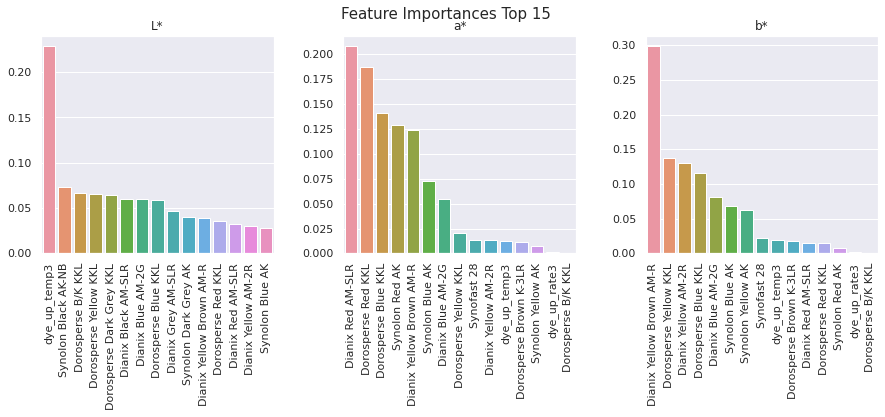

In [129]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 15
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model_origin.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=90)
    g.set_title(y.columns[i])

plt.show()

### 파생변수(염료 구성비)만 사용

In [130]:
X_der = pd.concat([df.iloc[:, 88:116], df.iloc[:, 152:-3]], axis=1)
# print(X_der.shape, X_der.columns)

X_train, X_test, y_train, y_test = train_test_split(X_der, y, test_size=0.2, random_state=SEED)
df_train_pred_origin, df_pred_origin, model_der = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 46) (1347, 3)
Test : (337, 46) (337, 3)

[Train] R-squared: 0.84651
[Test]  R-squared: 0.63854
[Train] MSE: 80.3747
[Test]  MSE: 173.2279

[Train] ΔE < 1 : 443 / 1347 = 0.3289
[Train] Average of ΔE : 5.5219
[Test]  ΔE < 1 : 43 / 337 = 0.1276
[Test]  Average of ΔE : 8.4874


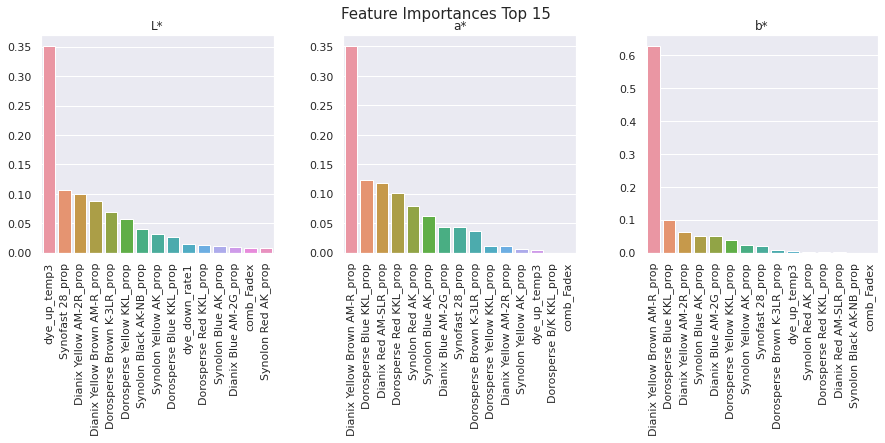

In [131]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 15
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model_der.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=90)
    g.set_title(y.columns[i])

plt.show()

### 원본 투입량 변수 + 파생변수

In [132]:
X_both = pd.concat([df.iloc[:, 70:116], df.iloc[:, 152:-3]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_both, y, test_size=0.2, random_state=SEED)
df_train_pred_origin, df_pred_origin, model_both = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 64) (1347, 3)
Test : (337, 64) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.98235
[Train] MSE: 0.021
[Test]  MSE: 8.6446

[Train] ΔE < 1 : 1346 / 1347 = 0.9993
[Train] Average of ΔE : 0.0989
[Test]  ΔE < 1 : 204 / 337 = 0.6053
[Test]  Average of ΔE : 1.4829


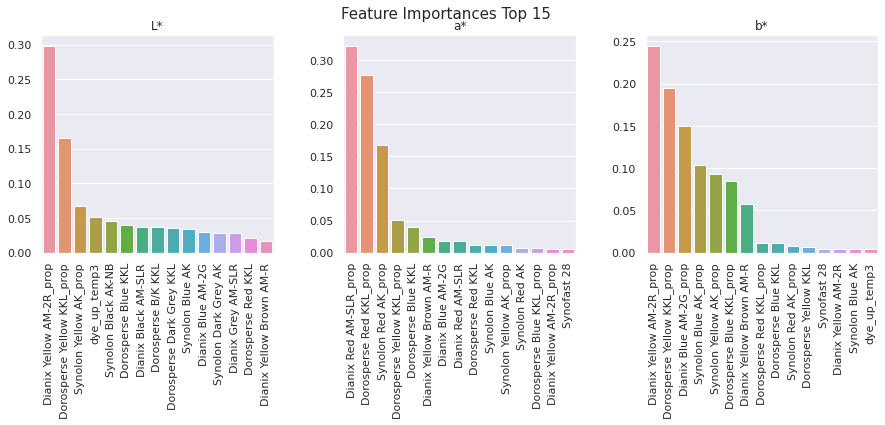

In [133]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 15
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model_both.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=90)
    g.set_title(y.columns[i])

plt.show()

## 둘다 포함 + 후처리/후가공 변수

In [134]:
X_100 = df.iloc[:, 70:-3]

X_train, X_test, y_train, y_test = train_test_split(X_100, y, test_size=0.2, random_state=SEED)
df_train_pred_origin, df_pred_origin, model_100 = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 100) (1347, 3)
Test : (337, 100) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.98247
[Train] MSE: 0.0211
[Test]  MSE: 8.5855

[Train] ΔE < 1 : 1345 / 1347 = 0.9985
[Train] Average of ΔE : 0.0990
[Test]  ΔE < 1 : 204 / 337 = 0.6053
[Test]  Average of ΔE : 1.4812


36개의 후처리/후가공 변수를 포함해도 성능은 똑같다. 후처리/후가공 변수 불필요한 듯.

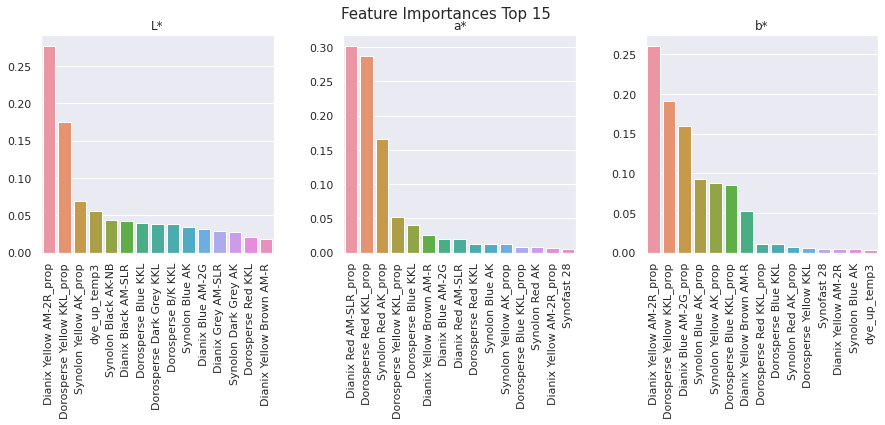

In [135]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 15
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model_100.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=90)
    g.set_title(y.columns[i])

plt.show()

In [ ]:
|